In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import copy
import pickle
import pandas as pd
from tqdm import tqdm

def load_data():
    # 加载数据
    data = loadmat("mnist_all.mat")

    # print(data.keys())

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for i in range(10):
        temp_df = pd.DataFrame(data["train" + str(i)])
        temp_df['label'] = i
        train_data = train_data.append(temp_df)
        temp_df = pd.DataFrame(data["test" + str(i)])
        temp_df['label'] = i
        test_data = test_data.append(temp_df)

    train_data = shuffle(train_data)
    test_data = shuffle(test_data)

    train_labels = np.array(train_data['label'])
    test_labels = np.array(test_data['label'])


    train_data = train_data.drop('label', axis=1)
    test_data = test_data.drop('label', axis=1)

    train_data = np.array(train_data) / 255
    test_data = np.array(test_data) / 255

    return train_data, test_data, train_labels, test_labels

X_train, X_test, y_train, y_test = load_data()

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

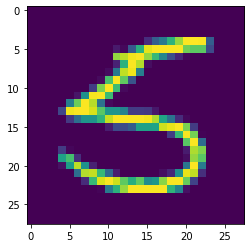

In [120]:
plt.imshow(X_train[5].reshape(1, 28, 28).reshape(28, 28))
plt.show()

In [121]:
# only for one example
class Linear:
    def __init__(self, input_dim, output_dim):
        self.w = np.random.randn(output_dim, input_dim)
        self.b = np.random.randn(output_dim, 1)
        self.x = None
        self.dw = None
        self.db = None
        
        self.type = 'linear'
        
    def forward(self, x):
        self.x = x
        
        out = np.dot(self.w, x) + self.b
        
        return out
    
    def backward(self, dout):
        self.dw = np.dot(dout, self.x.T)
        self.db = dout
        
        return np.dot(self.w.T, dout)

In [122]:
class softmax:
    def __init__(self):
        self.p = None
        self.t = None
    
    def forward(self, a, t):
        self.t = t
        c = np.max(a)
        exp_a = np.exp(a - c)
        sum_exp_a = np.sum(exp_a)
        p = exp_a / sum_exp_a
        
        self.p = p
        
        _p = np.log(p + 1e-5)

        loss = np.sum(-_p*t)
        
        return loss
    def backward(self):
        
        return self.p - self.t

In [123]:
def MakeOneHot(class_num, x):
    true = np.zeros(class_num)
    true[x] = 1
    return true.reshape(class_num, -1)

In [124]:
def sigmoid(x):
    i = 0
    for k in x:
        if k[0] >=0:
            k[0] = 1.0/(1+np.exp(-k[0]))
        else:
            k[0] = np.exp(k[0])/(1+np.exp(k[0]))
    return x

In [161]:
class LSTM:
    def __init__(self, hidden_size, input_size):
        
        self.type = 'lstm_rnn'
        
        self.Wf = np.random.randn(hidden_size, hidden_size)
        self.Wi = np.random.randn(hidden_size, hidden_size)
        self.Wo = np.random.randn(hidden_size, hidden_size)
        self.Wa = np.random.randn(hidden_size, hidden_size)
        
        self.Uf = np.random.randn(hidden_size, input_size)
        self.Ui = np.random.randn(hidden_size, input_size)
        self.Uo = np.random.randn(hidden_size, input_size)
        self.Ua = np.random.randn(hidden_size, input_size)
        
        self.V = np.random.randn(input_size, hidden_size)
        
        self.bf = 0
        self.bi = 0
        self.bo = 0
        self.ba = 0
        self.bv = 0
        
        self.hidden_size = hidden_size
        self.input_size = input_size
    
    def forward(self, x):
        self.x = x
        self.seq_len = x.shape[0]
        
        self.h_list = np.random.randn(self.seq_len + 1, self.hidden_size, 1)
        self.a_list = np.random.randn(self.seq_len + 1, self.hidden_size, 1)
        self.i_list = np.random.randn(self.seq_len + 1, self.hidden_size, 1)
        self.o_list = np.random.randn(self.seq_len + 1, self.hidden_size, 1)
        self.c_list = np.random.randn(self.seq_len + 1, self.hidden_size, 1)
        self.f_list = np.random.randn(self.seq_len + 1, self.hidden_size, 1)
        
        for i in range(x.shape[0]):
            self.f_list[i] = sigmoid(np.dot(self.Wf, self.h_list[i-1]) + \
                                     np.dot(self.Uf, x[i]) + self.bf)
            self.i_list[i] = sigmoid(np.dot(self.Wi, self.h_list[i-1]) + np.dot(self.Ui, x[i]) + self.bi)
            self.o_list[i] = sigmoid(np.dot(self.Wo, self.h_list[i-1]) + np.dot(self.Uo, x[i]) + self.bo)
            self.a_list[i] = np.tanh(np.dot(self.Wa, self.h_list[i-1]) + np.dot(self.Ua, x[i]) + self.ba)
            self.c_list[i] = self.f_list[i]*self.c_list[i-1] + self.i_list[i]*self.a_list[i]
            self.h_list[i] = self.o_list[i]*np.tanh(self.c_list[i])
            
        out = np.dot(self.V, self.h_list[i]) + self.bv
            
        return out
    def backward(self, dout):
        
        dc_dWf = np.dot(self.c_list[-1]*self.f_list[0]*(1-self.f_list[0]), self.h_list[-1].T)
        dh_dWf = np.multiply((1-np.tanh(self.c_list[0])*np.tanh(self.c_list[0]))*self.o_list[0], dc_dWf)
        
        dc_dWi = np.dot(self.a_list[0]*self.i_list[0]*(1-self.i_list[0]), self.h_list[-1].T)
        dh_dWi = np.multiply(self.o_list[0]*(1-np.tanh(self.c_list[0])*np.tanh(self.c_list[0])), dc_dWi)
        
        dh_dWo = np.dot(np.tanh(self.c_list[0])*self.o_list[0]*(1-self.o_list[0]), self.h_list[-1].T)
        
        dh_dUo = np.dot(np.tanh(self.c_list[0])*self.o_list[0]*(1-self.o_list[0]), self.x[0].T)
        
        dh_dbo = np.tanh(self.c_list[0])*self.o_list[0]*(1-self.o_list[0])
        
        dc_dUf = np.dot(self.c_list[-1]*self.f_list[0]*(1-self.f_list[0]), self.x[0].T)
        dh_dUf = np.multiply(self.o_list[0]*(1-np.tanh(self.c_list[0])*np.tanh(self.c_list[0])), dc_dUf)
        
        dc_dUi = np.dot(self.a_list[0]*self.i_list[0]*(1-self.i_list[0]), self.x[0].T)
        dh_dUi = np.multiply(self.o_list[0]*(1-np.tanh(self.c_list[0])*np.tanh(self.c_list[0])), dc_dUi)
        
        dc_dUa = np.dot(self.i_list[0]*(1-self.a_list[0]*self.a_list[0]), self.x[0].T)
        dh_dUa = np.multiply(self.o_list[0]*(1-np.tanh(self.c_list[0])*np.tanh(self.c_list[0])), dc_dUa)
        
        dc_dWa = np.dot(self.i_list[0]*(1-self.a_list[0]*self.a_list[0]), self.h_list[-1].T)
        dh_dWa = np.multiply(self.o_list[0]*(1-np.tanh(self.c_list[0])*np.tanh(self.c_list[0])), dc_dWa)
        
        dc_dUo = 0
        dc_dWo = 0
        dc_dbo = 0
        
        dc_dbf = self.c_list[-1]*self.f_list[0]*(1-self.f_list[0])
        dh_dbf = np.multiply(self.o_list[0]*(1-np.tanh(self.c_list[0])*np.tanh(self.c_list[0])), dc_dbf)
                
        dc_dbi = self.a_list[0]*self.i_list[0]*(1-self.i_list[0])
        dh_dbi = np.multiply(self.o_list[0]*(1-np.tanh(self.c_list[0])*np.tanh(self.c_list[0])), dc_dbi)
        
        dc_dba = self.i_list[0]*(1-self.a_list[0]*self.a_list[0])
        dh_dba = np.multiply(self.o_list[0]*(1-np.tanh(self.c_list[0])*np.tanh(self.c_list[0])), dc_dba)
        
        for i in range(1, self.seq_len):
            
            temp_dc_dWf = copy.deepcopy(dc_dWf)
            temp_dc_dWi = copy.deepcopy(dc_dWi)
            temp_dc_dUf = copy.deepcopy(dc_dUf)
            temp_dc_dUi = copy.deepcopy(dc_dUi)
            temp_dc_dUa = copy.deepcopy(dc_dUa)
            temp_dc_dWa = copy.deepcopy(dc_dWa)
            temp_dc_dUo = copy.deepcopy(dc_dUo)
            temp_dc_dWo = copy.deepcopy(dc_dWo)
            temp_dc_dbf = copy.deepcopy(dc_dbf)
            temp_dc_dbi = copy.deepcopy(dc_dbi)
            temp_dc_dba = copy.deepcopy(dc_dba)
            temp_dc_dbo = copy.deepcopy(dc_dbo)
            
            dc_dba = np.multiply(self.f_list[i], dc_dba) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dba) + \
                     np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dba) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dba) + \
                     self.i_list[i]*(1-self.a_list[i]*self.a_list[i])
            
            dh_dba = np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dba) + \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dba)
            
            
            dc_dbf = np.multiply(self.f_list[i], dc_dbf) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dbf) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dbf) + \
                     self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i]) + \
                     np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dbf)
            
            dh_dbf = np.multiply((1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i]))*self.o_list[i], temp_dc_dbf) + \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dbf)
            
            dc_dbi = np.multiply(self.f_list[i], dc_dbi) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dbi) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dbi) + \
                     np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dbi) + \
                     self.a_list[i]*self.i_list[i]*(1-self.i_list[i])
            
            dh_dbi = np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dbi) +  \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dbi)
            
            
            dc_dWf = np.multiply(self.f_list[i], dc_dWf) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dWf) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dWf) + \
                     np.dot(self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i]), self.h_list[i-1].T) + \
                     np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dWf)
            
            dh_dWf = np.multiply((1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i]))*self.o_list[i], temp_dc_dWf) + \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dWf)
            
            dc_dWa = np.multiply(self.f_list[i], dc_dWa) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dWa) + \
                     np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dWa) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dWa) + \
                     np.dot(self.i_list[i]*(1-self.a_list[i]*self.a_list[i]), self.h_list[i-1].T)
            
            dh_dWa = np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dWa) + \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dWa)

            dc_dWi = np.multiply(self.f_list[i], dc_dWi) + \
                     np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dWi) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*self.a_list[i]*(1-self.a_list[i])), dh_dWi) + \
                     np.dot(self.a_list[i]*self.i_list[i]*(1-self.i_list[i]), self.h_list[i-1].T) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dWi)

            
            dh_dWi = np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dWi) + \
                     np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dWi)
            
            dc_dUa = np.multiply(self.f_list[i], dc_dUa) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dUa) + \
                     np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dUa) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dUa) + \
                     np.dot(self.i_list[i]*(1-self.a_list[i]*self.a_list[i]), self.x[i].T)
            
            dh_dUa = np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dUa) + \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dUa)
            
            
            dc_dUf = np.multiply(self.f_list[i], dc_dUf) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dUf) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dUf) + \
                     np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dUf) + \
                     np.dot(self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i]), self.x[i].T)
            
            dh_dUf = np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dUf) +  \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dUf)
            
            dc_dUi = np.multiply(self.f_list[i], dc_dUi) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dUi) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dUi) + \
                     np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dUi) + \
                     np.dot(self.a_list[i]*self.i_list[i]*(1-self.i_list[i]), self.x[i].T)
            
            dh_dUi = np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dUi) +  \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dUi)
            
            dc_dWo = np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dWo) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dWo) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dWo)
            
            dh_dWo = np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dWo) + \
                     np.dot(np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i]), self.h_list[i-1].T) + \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dWo)
            
            dc_dUo = np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dUo) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dUo) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dUo)
            
            dh_dUo = np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dUo) + \
                     np.dot(np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i]), self.x[i].T) + \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dUo)
            
            dc_dbo = np.multiply(np.dot(self.Wf.T, self.c_list[i-1]*self.f_list[i]*(1-self.f_list[i])), dh_dbo) + \
                     np.multiply(np.dot(self.Wi.T, self.a_list[i]*self.i_list[i]*(1-self.i_list[i])), dh_dbo) + \
                     np.multiply(np.dot(self.Wa.T, self.i_list[i]*(1-self.a_list[i]*self.a_list[i])), dh_dbo)
            
            dh_dbo = np.multiply(self.o_list[i]*(1-np.tanh(self.c_list[i])*np.tanh(self.c_list[i])), temp_dc_dbo) + \
                     np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i]) + \
                     np.multiply(np.dot(self.Wo.T, np.tanh(self.c_list[i])*self.o_list[i]*(1-self.o_list[i])), dh_dbo)
             
        self.dWf = np.multiply(np.dot(self.V.T, dout), dh_dWf)
        self.dWi = np.multiply(np.dot(self.V.T, dout), dh_dWi)
        self.dUf = np.multiply(np.dot(self.V.T, dout), dh_dUf)
        self.dUi = np.multiply(np.dot(self.V.T, dout), dh_dUi)
        self.dUa = np.multiply(np.dot(self.V.T, dout), dh_dUa)
        self.dUo = np.multiply(np.dot(self.V.T, dout), dh_dUo)
        self.dWo = np.multiply(np.dot(self.V.T, dout), dh_dWo)
        self.dWa = np.multiply(np.dot(self.V.T, dout), dh_dWa)

        self.dV = np.dot(dout, self.h_list[i].T)
        self.dbv = np.sum(dout)
        self.dbf = np.sum(np.multiply(np.dot(self.V.T, dout), dh_dbf))
        self.dbi = np.sum(np.multiply(np.dot(self.V.T, dout), dh_dbi))
        self.dba = np.sum(np.multiply(np.dot(self.V.T, dout), dh_dba))
        self.dbo = np.sum(np.multiply(np.dot(self.V.T, dout), dh_dbo))

In [162]:
# test case
# a = np.array([[1], [2]])
# b = np.array([[2,4],[3,6]])
# c = np.multiply(b, a)
# c

In [163]:
# test case
# a = np.array([[2, 4], [1, 2]])
# b = np.array([[2, 3]])
# c = np.multiply(a, b)
# c

In [164]:
hidden_size = 64
input_size = 196

In [165]:
model = []

model.append(LSTM(input_size=input_size, hidden_size=hidden_size))
model.append(Linear(input_size, 10))
model.append(softmax())

for layer in model:
    print(layer)

In [166]:
class LSTMRNN:
    def __init__(self, model):
        self.model = model
    
    def forward(self, x, y):

        for layer in self.model[0:1]:
            
            x = layer.forward(x)
            
        x = x.reshape(-1, 1)
        
        x = model[-2].forward(x)
        
        x = model[-1].forward(x, y)
        return x
    
    def backward(self):
        dout = model[-1].backward()
        
        index = len(model) - 2
        while index >= 0:
            dout = model[index].backward(dout)
            index -= 1

In [167]:
net = LSTMRNN(model=model)
best_model = None
best_acc = -1

epochs = 20
lr = 0.005
for epoch in range(epochs):
    loss = 0
    for i in range(len(X_train)):

        loss += net.forward(X_train[i].reshape(int(784/input_size), input_size, 1), MakeOneHot(10, y_train[i]))
        
        if np.isnan(loss):
            exit(1)
        
        net.backward()
        
        # update parameters
        index = len(net.model) - 2
        while index >= 0:
            if net.model[index].type == 'linear':
                
                net.model[index].w -= lr * net.model[index].dw
                net.model[index].b -= lr * net.model[index].db
            if net.model[index].type == 'lstm_rnn':
                net.model[index].Wf -= lr * net.model[index].dWf
                net.model[index].Wi -= lr * net.model[index].dWi
                net.model[index].Wa -= lr * net.model[index].dWa
                net.model[index].Wo -= lr * net.model[index].dWo
                net.model[index].V -= lr * net.model[index].dV
                net.model[index].bv -= lr * net.model[index].dbv
                net.model[index].bi -= lr * net.model[index].dbi
                net.model[index].ba -= lr * net.model[index].dba
                net.model[index].bf -= lr * net.model[index].dbf
                net.model[index].bo -= lr * net.model[index].dbo
                net.model[index].Uf -= lr * net.model[index].dUf
                net.model[index].Ui -= lr * net.model[index].dUi
                net.model[index].Ua -= lr * net.model[index].dUa
                net.model[index].Uo -= lr * net.model[index].dUo
            index -= 1
        
    print("epoch: {}/{} loss: {}".format(epoch + 1, epochs, loss / len(X_train)))

    valid_correct = 0
    for i in range(len(X_valid)):
        net.forward(X_valid[i].reshape(int(784/input_size), input_size, 1), MakeOneHot(10, y_valid[i]))
        
        if np.argmax(net.model[-1].p) == y_valid[i]:
            valid_correct += 1
    
    acc = valid_correct / len(X_valid)
    print("Valid Acc: {}".format(acc))
    if best_acc < acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        print("get new model!")

test_net = LSTMRNN(best_model)
test_correct = 0
for i in range(len(X_test)):
    test_net.forward(X_test[i].reshape(int(784/input_size), input_size, 1), MakeOneHot(10, y_test[i]))

    if np.argmax(net.model[-1].p) == y_test[i]:
        test_correct += 1
print("Test Acc: {}".format(test_correct / len(X_test)))

epoch: 1/20 loss: 1.905794006681029
Valid Acc: 0.4751666666666667
get new model!
epoch: 2/20 loss: 1.4411582127911637
Valid Acc: 0.553
get new model!
epoch: 3/20 loss: 1.2445909099215022
Valid Acc: 0.6
get new model!
epoch: 4/20 loss: 1.1298041655543236
Valid Acc: 0.6446666666666667
get new model!
epoch: 5/20 loss: 1.018771239706427
Valid Acc: 0.6845833333333333
get new model!
epoch: 6/20 loss: 0.9234764520502695
Valid Acc: 0.7109166666666666
get new model!
epoch: 7/20 loss: 0.8625094240811545
Valid Acc: 0.72075
get new model!
epoch: 8/20 loss: 0.8058280735228535
Valid Acc: 0.7426666666666667
get new model!
epoch: 9/20 loss: 0.7767017534188041
Valid Acc: 0.74025
epoch: 10/20 loss: 0.7402284109202263
Valid Acc: 0.7576666666666667
get new model!
epoch: 11/20 loss: 0.7134361572169053
Valid Acc: 0.7665833333333333
get new model!
epoch: 12/20 loss: 0.6868986786884456
Valid Acc: 0.77525
get new model!
epoch: 13/20 loss: 0.6559551275540992
Valid Acc: 0.7914166666666667
get new model!
epoch: 1